In [263]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [264]:
import numpy as np
import pandas as pd

import csv as csv
import sklearn
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm as lgb

from utils import save_to_csv, reduce_memory_usage,custom_kfold_scorer 

In [265]:
train_df = pd.read_csv("./train_1.csv")
test_df = pd.read_csv("./test_1.csv")
mrt_df = pd.read_csv("./auxiliary-data/sg-train-stations.csv")

In [266]:
mrt_df.head()

,name,codes,lat,lng,opening_year,type
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt


In [267]:
mrt_df.isnull().any()
mrt_df['type'].unique()

array(['mrt', 'other'], dtype=object)

There are some null values. We will drop all the datapoints with null values. LRT station with type="other" have null values in opening year. So in essence we are dropping all LRT stations from analysis.

In [268]:
mrt_df = mrt_df.dropna()
mrt_df['type'].unique()

array(['mrt'], dtype=object)

In [269]:
mrt_df.isnull().any()

name            False
codes           False
lat             False
lng             False
opening_year    False
type            False
dtype: bool

In [270]:
print("Min opening year of mrt station : ",mrt_df['opening_year'].min())
print("Max opening year of mrt station : ",mrt_df['opening_year'].max())

Min opening year of mrt station :  1987.0
Max opening year of mrt station :  2031.0


In [271]:
print("Min resale year of hdb : ",train_df['year'].min())
print("Max resale year of hdb : ",train_df['year'].max())

Min resale year of hdb :  2000
Max resale year of hdb :  2020


### Checking for duplicate values

In [272]:
mrt_df.duplicated().any()

False

### Dropping columns which are not required

In [273]:
mrt_df = mrt_df.drop(columns=['codes','type'])

In [274]:
mrt_df.head()

,name,lat,lng,opening_year
0,Eunos,1.319778,103.903252,1989.0
1,Chinese Garden,1.342352,103.732596,1988.0
2,Khatib,1.417383,103.832980,1988.0
3,Kranji,1.425177,103.762165,1996.0
4,Redhill,1.289562,103.816816,1988.0


### Club latitude and longitude together and drop 'lat' and 'lng' columns

In [275]:
mrt_df['lat_long'] = list(zip(mrt_df.lat, mrt_df.lng))

In [276]:
mrt_df = mrt_df.drop(columns=['lat','lng'])

In [277]:
mrt_df.head()

,name,opening_year,lat_long
0,Eunos,1989.0,"(1.3197782848869883, 103.90325213335886)"
1,Chinese Garden,1988.0,"(1.3423521542087522, 103.73259640485368)"
2,Khatib,1988.0,"(1.4173827034869275, 103.8329795744054)"
3,Kranji,1996.0,"(1.4251770321043908, 103.76216507762184)"
4,Redhill,1988.0,"(1.2895620597351771, 103.81681633682066)"


# ADD SOME PLOTS HERE

### Extract lat_long and year columns from train and test data sets

In [278]:
train_df_temp = train_df[["lat_long", "year"]]
test_df_temp = test_df[["lat_long", "year"]]

### Drop duplicate locations

In [279]:
train_df_temp = train_df_temp.drop_duplicates(subset=['lat_long'])
test_df_temp = test_df_temp.drop_duplicates(subset=['lat_long'])

### Add columns to store the nearest mrt and its distance

In [280]:
train_df_temp["nearest_mrt"] = str("--")
train_df_temp["nearest_mrt_distance"] = math.inf
test_df_temp["nearest_mrt"] = str("--")
test_df_temp["nearest_mrt_distance"] = math.inf
train_df_temp = train_df_temp.reset_index()
test_df_temp = test_df_temp.reset_index()

In [281]:
mrt_df = mrt_df.reset_index()

In [282]:
mrt_df.head()

,index,name,opening_year,lat_long
0,0,Eunos,1989.0,"(1.3197782848869883, 103.90325213335886)"
1,1,Chinese Garden,1988.0,"(1.3423521542087522, 103.73259640485368)"
2,2,Khatib,1988.0,"(1.4173827034869275, 103.8329795744054)"
3,3,Kranji,1996.0,"(1.4251770321043908, 103.76216507762184)"
4,4,Redhill,1988.0,"(1.2895620597351771, 103.81681633682066)"


In [283]:
train_df_temp.head()

,index,lat_long,year,nearest_mrt,nearest_mrt_distance
0,0,"(1.3690080642700195, 103.95869445800781)",2001,--,inf
1,1,"(1.3990070819854736, 103.90699005126953)",2014,--,inf
2,2,"(1.3883482217788696, 103.87381744384766)",2020,--,inf
3,3,"(1.3184930086135864, 103.7667007446289)",2000,--,inf
4,4,"(1.3481495380401611, 103.74266052246094)",2013,--,inf


In [284]:
test_df_temp.head()

,index,lat_long,year,nearest_mrt,nearest_mrt_distance
0,0,"(1.3465807437896729, 103.74408721923828)",2004,--,inf
1,1,"(1.3576176166534424, 103.96138000488281)",2001,--,inf
2,2,"(1.337803840637207, 103.74199676513672)",2002,--,inf
3,3,"(1.380083680152893, 103.84957122802734)",2015,--,inf
4,4,"(1.3139597177505493, 103.76982879638672)",2004,--,inf


Converting our dataframe to numpy arrays for faster computation

In [285]:
train_df_temp_numpy = train_df_temp.to_numpy()
test_df_temp_numpy = test_df_temp.to_numpy()
mrt_df_numpy = mrt_df.to_numpy()

In [286]:
print("Shape of train_df_temp_numpy :",np.shape(train_df_temp_numpy))
print("Shape of test_df_temp_numpy :",np.shape(test_df_temp_numpy))
print("Shape of mrt_df_numpy :",np.shape(mrt_df_numpy))

Shape of train_df_temp_numpy : (9138, 5)
Shape of test_df_temp_numpy : (8990, 5)
Shape of mrt_df_numpy : (126, 4)


In [287]:
print("Get distance for each location and update nearest mrt and its distance")
for i in range(len(train_df_temp_numpy)):
    min_dist = math.inf
    min_dist_mrt = ""
    hdb_location = train_df_temp_numpy[i][1]
    hdb_location = eval(hdb_location)
    resale_year = train_df_temp_numpy[i][2]
    for j in range(len(mrt_df_numpy)):
        opening_year = mrt_df_numpy[j][2]
        if opening_year <= resale_year:
            mrt_location = mrt_df_numpy[j][3]
            distance = geopy.distance.great_circle(hdb_location, mrt_location).km
            if distance < min_dist:
                min_dist = distance
                min_dist_mrt = mrt_df_numpy[j][1]
    train_df_temp_numpy[i][3] = min_dist_mrt
    train_df_temp_numpy[i][4] = min_dist

print("Add nearest_mrt and nearest_mrt_distance to dataframe")
for i in range(len(train_df_temp_numpy)):
    dataframe_index = train_df_temp_numpy[i][0]
    train_df_temp.loc[i, "nearest_mrt"] = train_df_temp_numpy[i][3]
    train_df_temp.loc[i, "nearest_mrt_distance"] = train_df_temp_numpy[i][4]

Get distance for each location and update nearest mrt and its distance
Add nearest_mrt and nearest_mrt_distance to dataframe


In [288]:
print("Get distance for each location and update nearest mrt and its distance")
for i in range(len(test_df_temp_numpy)):
    min_dist = math.inf
    min_dist_mrt = ""
    hdb_location = test_df_temp_numpy[i][1]
    hdb_location = eval(hdb_location)
    resale_year = train_df_temp_numpy[i][2]
    for j in range(len(mrt_df_numpy)):
        opening_year = mrt_df_numpy[j][2]
        if opening_year <= resale_year:
            mrt_location = mrt_df_numpy[j][3]
            distance = geopy.distance.great_circle(hdb_location, mrt_location).km
            if distance < min_dist:
                min_dist = distance
                min_dist_mrt = mrt_df_numpy[j][1]
    test_df_temp_numpy[i][3] = min_dist_mrt
    test_df_temp_numpy[i][4] = min_dist

print("Add nearest_mrt and nearest_mrt_distance to dataframe")
for i in range(len(test_df_temp_numpy)):
    dataframe_index = test_df_temp_numpy[i][0]
    test_df_temp.loc[i, "nearest_mrt"] = test_df_temp_numpy[i][3]
    test_df_temp.loc[i, "nearest_mrt_distance"] = test_df_temp_numpy[i][4]

Get distance for each location and update nearest mrt and its distance
Add nearest_mrt and nearest_mrt_distance to dataframe


In [289]:
train_df_temp.head()

,index,lat_long,year,nearest_mrt,nearest_mrt_distance
0,0,"(1.3690080642700195, 103.95869445800781)",2001,Pasir Ris,1.137305
1,1,"(1.3990070819854736, 103.90699005126953)",2014,Punggol,0.823520
2,2,"(1.3883482217788696, 103.87381744384766)",2020,Buangkok,2.230426
3,3,"(1.3184930086135864, 103.7667007446289)",2000,Clementi,0.423286
4,4,"(1.3481495380401611, 103.74266052246094)",2013,Bukit Batok,0.773956


In [290]:
test_df_temp.head()

,index,lat_long,year,nearest_mrt,nearest_mrt_distance
0,0,"(1.3465807437896729, 103.74408721923828)",2004,Bukit Batok,0.667364
1,1,"(1.3576176166534424, 103.96138000488281)",2001,Simei,1.833560
2,2,"(1.337803840637207, 103.74199676513672)",2002,Jurong East,0.518267
3,3,"(1.380083680152893, 103.84957122802734)",2015,Yio Chu Kang,0.546624
4,4,"(1.3139597177505493, 103.76982879638672)",2004,Clementi,0.515598


### We will now merge the result with our original data frames

In [291]:
temp = train_df_temp[["lat_long", "nearest_mrt", "nearest_mrt_distance"]]
train_df = pd.merge(train_df, temp, on="lat_long", how='left')
print("Changing datatype of nearest_mrt_distance to float32")
train_df[['nearest_mrt_distance']] = train_df[['nearest_mrt_distance']].astype('float32')

temp = test_df_temp[["lat_long", "nearest_mrt", "nearest_mrt_distance"]]
test_df = pd.merge(test_df, temp, on="lat_long", how='left')
print("Changing datatype of nearest_mrt_distance to float32")
test_df[['nearest_mrt_distance']] = test_df[['nearest_mrt_distance']].astype('float32')

Changing datatype of nearest_mrt_distance to float32
Changing datatype of nearest_mrt_distance to float32


### Nearest MRT and its distance from HDB has been added to our dataframe

In [292]:
train_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,resale_price,month_no,year,storey,lat_long,nearest_mrt,nearest_mrt_distance
0,pasir ris,4-room,440,pasir ris drive 4,118.0,model a,1989,pasir ris drive,pasir ris,east region,209700.0,8,2001,2.0,"(1.3690080642700195, 103.95869445800781)",Pasir Ris,1.137305
1,punggol,5-room,196B,punggol field,110.0,improved,2003,punggol field,punggol,north-east region,402300.0,10,2014,11.0,"(1.3990070819854736, 103.90699005126953)",Punggol,0.823520
2,sengkang,5-room,404A,fernvale lane,112.0,premium apartment,2004,fernvale,sengkang,north-east region,351000.0,9,2020,2.0,"(1.3883482217788696, 103.87381744384766)",Buangkok,2.230426
3,clementi,3-room,375,clementi avenue 4,67.0,new generation,1980,clementi north,clementi,west region,151200.0,10,2000,8.0,"(1.3184930086135864, 103.7667007446289)",Clementi,0.423286
4,bukit batok,3-room,163,bukit batok street 11,73.0,model a,1985,bukit batok west,bukit batok,west region,318600.0,1,2013,8.0,"(1.3481495380401611, 103.74266052246094)",Bukit Batok,0.773956


In [293]:
test_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,month_no,year,storey,lat_long,nearest_mrt,nearest_mrt_distance
0,bukit batok,4-room,186,bukit batok west avenue 6,94.0,new generation,1989,bukit batok west,bukit batok,west region,1,2004,5.0,"(1.3465807437896729, 103.74408721923828)",Bukit Batok,0.667364
1,tampines,5-room,366,tampines street 34,122.0,improved,1997,tampines east,tampines,east region,11,2001,5.0,"(1.3576176166534424, 103.96138000488281)",Simei,1.833560
2,jurong east,3-room,206,jurong east street 21,67.0,new generation,1982,toh guan,jurong east,west region,7,2002,2.0,"(1.337803840637207, 103.74199676513672)",Jurong East,0.518267
3,ang mo kio,3-room,180,Ang Mo Kio Avenue 5,82.0,new generation,1981,yio chu kang east,ang mo kio,north-east region,4,2015,5.0,"(1.380083680152893, 103.84957122802734)",Yio Chu Kang,0.546624
4,clementi,5-room,356,clementi avenue 2,117.0,standard,1978,clementi north,clementi,west region,4,2004,2.0,"(1.3139597177505493, 103.76982879638672)",Clementi,0.515598


# ADD SOME PLOTS HERE

<AxesSubplot:>

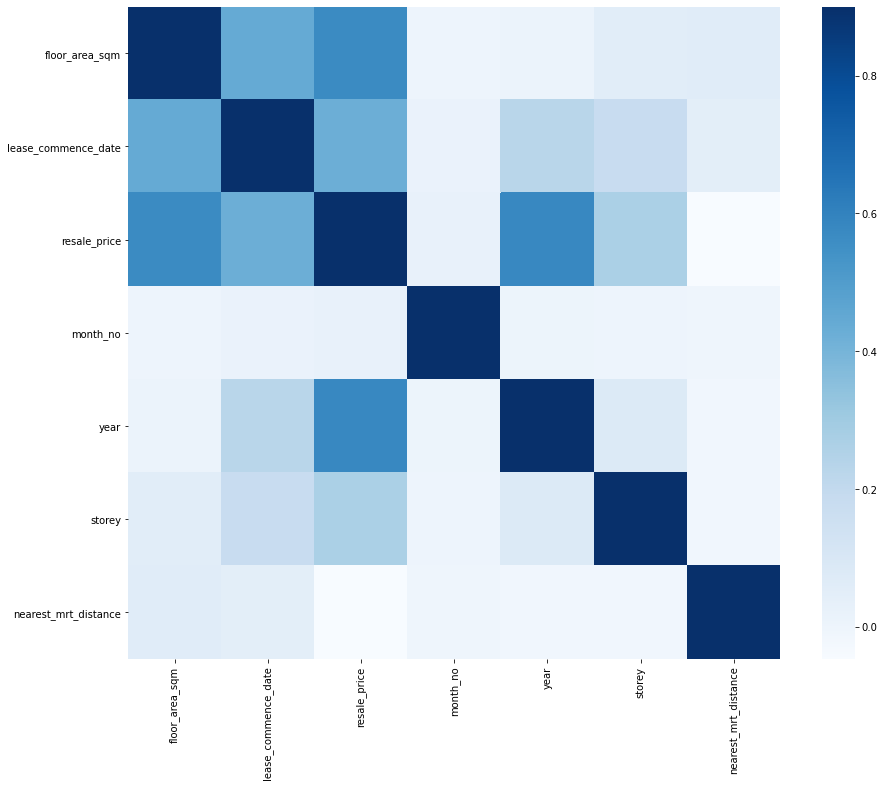

In [294]:
corr = train_df.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [295]:
corr[['resale_price']].sort_values(by='resale_price',ascending=False).style.background_gradient(cmap='viridis', axis=None)

,resale_price
resale_price,1.000000
year,0.578717
floor_area_sqm,0.570385
lease_commence_date,0.423578
storey,0.269431
month_no,0.025448
nearest_mrt_distance,-0.046656


### Reduce the size of dataframe to save memory during training

In [296]:
train_df, _ = reduce_memory_usage(train_df)
test_df, _ = reduce_memory_usage(test_df)

Memory usage of properties dataframe is : 57.64244079589844  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  43.64356231689453  MB
This is  75.71428571428571 % of the initial size
Memory usage of properties dataframe is : 13.587272644042969  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  10.499256134033203  MB
This is  77.27272727272727 % of the initial size


### Segregate the columns

In [297]:
integer_columns = [
    "lease_commence_date",
    "storey",
    "month_no",
    "year",
    "nearest_mrt_distance"
]

float_columns = [
    "floor_area_sqm",
]

target_column = [
    "resale_price"
]

## Categorical columns need to be encoded before training
categorical_columns = [
    "town",
    "flat_type",
    "flat_model",
    "subzone",
    "planning_area",
    "region"
]

## We will drop these columns before training
drop_columns = [
    "lat_long",
    "block",
    "street_name",
    "nearest_mrt"
]

### Drop the selected columns

In [298]:
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

### One hot encode categorical columns

In [299]:
for col in categorical_columns:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[col], prefix=col)],axis=1)
train_df = train_df.drop(columns=categorical_columns)

for col in categorical_columns:
    test_df = pd.concat([test_df, pd.get_dummies(test_df[col], prefix=col)],axis=1)
test_df = test_df.drop(columns=categorical_columns)

### Check if the columns in both test data and train data are same after one-hot encoding

In [300]:
columns_in_test_not_in_train = test_df.columns.difference(train_df.columns).tolist()
#print(columns_in_test_not_in_train)
columns_in_train_not_in_test = train_df.columns.difference((test_df.columns)).tolist()
columns_in_train_not_in_test.remove('resale_price')
#print(columns_in_train_not_in_test)
if not columns_in_test_not_in_train and not columns_in_train_not_in_test:
    print("Columns are same")

Columns are same


### Split training data into training and validation sets

In [301]:
train_data = train_df.sample(frac=1)
train_labels = train_data.pop('resale_price')
train_x, val_x, train_y, val_y = train_test_split(train_data,train_labels,train_size=0.8)

## Decision Tree

In [253]:
dt_3 = tree.DecisionTreeRegressor(max_depth=250,min_samples_split=15)
dt_3 = dt_3.fit(train_x, train_y)

In [254]:
train_prediction = dt_3.predict(train_x)
val_prediction = dt_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 13957.689575439914
Validation error(RMSE) : 22476.161974639675
R2 score for training data : 0.9884599702679785
R2 score for validation data : 0.9699177587222304


## Random Forest

In [250]:
rf_1 = RandomForestRegressor()

In [251]:
%%time
rf_1.fit(train_x,train_y)

Wall time: 11min 6s


RandomForestRegressor()

In [252]:
train_prediction = rf_1.predict(train_x)
val_prediction = rf_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 6989.991958423079
Validation error(RMSE) : 18279.980102643054
R2 score for training data : 0.9971057688758775
R2 score for validation data : 0.9801016382862472


## XGBOOST

In [256]:
xgb_model_2 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=50,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [257]:
%%time
xgb_model_2.fit(train_x,train_y)

Wall time: 3min 46s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=50,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [258]:
train_prediction = xgb_model_2.predict(train_x)
val_prediction = xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 11960.533
Validation error(RMSE) : 22146.086
R2 score for training data : 0.9915261472989625
R2 score for validation data : 0.9707948212198949


## LightGBM

In [244]:
gbm_1 = lgb.LGBMRegressor()

In [245]:
gbm_1 = gbm_1.fit(train_x,train_y)

In [246]:
train_prediction = gbm_1.predict(train_x)
val_prediction = gbm_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 23423.758798616513
Validation error(RMSE) : 23618.763609228434
R2 score for training data : 0.9674992762704433
R2 score for validation data : 0.9667814858390025


In [247]:
gbm_2 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=10000,n_estimators=10000)

In [248]:
gbm_2 = gbm_2.fit(train_x,train_y)

In [249]:
train_prediction = gbm_2.predict(train_x)
val_prediction = gbm_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 11949.950723961809
Validation error(RMSE) : 16236.028743646613
R2 score for training data : 0.991541135148375
R2 score for validation data : 0.9843026801752415
